In [31]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression

from simulation import generate_dataset

In [32]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

In [33]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 1000
n_samples_test = 100
noise_scalar = 0.1

In [34]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
use_ols = False
i_from = 0
i_to = 1

In [35]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(d_list, scalars, n_targets, n_samples_train, n_samples_test,
                                                        noise_scalar)

first of all lets verify that Ridge regression with $\alpha = 0$ indeed is equivalent to linear regression

In [36]:
fit_intercept = True

ridge = Ridge(alpha=1, fit_intercept=fit_intercept, solver_params=dict(warn=False, n_targets_batch=1000))
ridge.fit(Xs_train[0], Y_train)
ridge_coef = ridge.coef_  # (n_features, n_targets)
ridge_coef

array([[-0.04101726,  0.11737147,  0.03090066, ...,  0.01300056,
        -0.05518163, -0.01885576],
       [ 0.02257515,  0.04643869, -0.01579667, ...,  0.04745779,
         0.00540591,  0.00867426],
       [-0.0353256 , -0.06782434,  0.07193627, ..., -0.02542111,
        -0.02481688,  0.05932226],
       ...,
       [ 0.06723881, -0.04651587, -0.02710609, ...,  0.05690432,
         0.10217792, -0.00402296],
       [-0.01627528,  0.02721303,  0.06433745, ...,  0.03375723,
        -0.00813786, -0.03292269],
       [-0.00493341,  0.00929343, -0.00939017, ..., -0.04605783,
        -0.01634718, -0.01060004]], shape=(300, 10000), dtype=float32)

In [37]:
linear = LinearRegression(fit_intercept=fit_intercept)
linear.fit(backend.to_numpy(Xs_train[0]), backend.to_numpy(Y_train))
linear_coef = linear.coef_  # (n_targets, n_features)
# swap rows and columns
linear_coef = linear_coef.T
linear_coef

array([[-0.04103907,  0.11746136,  0.03092226, ...,  0.01301236,
        -0.05522648, -0.01888138],
       [ 0.02260289,  0.04647618, -0.0158016 , ...,  0.0474871 ,
         0.00538592,  0.0086727 ],
       [-0.03535658, -0.06788047,  0.07201204, ..., -0.025443  ,
        -0.02483334,  0.05935757],
       ...,
       [ 0.06727806, -0.04656273, -0.02711561, ...,  0.05693753,
         0.10227937, -0.00403023],
       [-0.01630827,  0.0272343 ,  0.06437069, ...,  0.0337719 ,
        -0.00815594, -0.03294966],
       [-0.00493773,  0.00930383, -0.00939705, ..., -0.04607368,
        -0.01636487, -0.01058816]], shape=(300, 10000), dtype=float32)

In [38]:
assert np.allclose(linear_coef, ridge_coef, atol=1e-3)
assert np.allclose(ridge.intercept_, linear.intercept_, atol=1e-3)


compute on full feature sets for comparison

In [39]:
full_scores = []

for i in range(len(Xs_train)):
    full_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
    full_model.fit(Xs_train[i], Y_train)
    full_score = full_model.score(Xs_test[i], Y_test)
    full_scores.append(full_score)
full_scores

[array([0.4409606 , 0.4475758 , 0.46274263, ..., 0.46846145, 0.6047432 ,
        0.47528595], shape=(10000,), dtype=float32),
 array([0.4503429 , 0.48143774, 0.48668128, ..., 0.4645297 , 0.58345735,
        0.41780335], shape=(10000,), dtype=float32)]

# Feature to feature regression

In [40]:
if use_ols:
    feature_model = Ridge(alpha=1, solver_params=solver_params)
else:
    feature_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)

In [41]:
feature_scores = []
feature_model.fit(Xs_train[i_from], Xs_train[i_to])

RidgeCV(alphas=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
        cv=10,
        solver_params={'n_targets_batch': 1000,
                       'score_func': <function r2_score at 0x748bbea14040>,
                       'warn': False})

In [42]:
X_predict_train = feature_model.predict(Xs_train[i_from])
X_predict_test = feature_model.predict(Xs_test[i_from])
X_predict_train = backend.asarray(X_predict_train)
X_predict_test = backend.asarray(X_predict_test)

<Axes: ylabel='Count'>

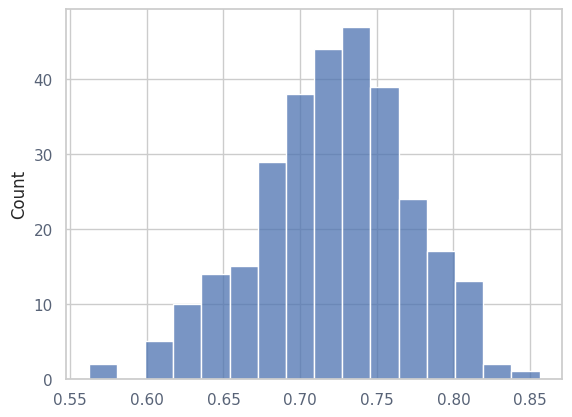

In [43]:
feature_score = feature_model.score(X_predict_test, Xs_test[i_to])
sns.histplot(backend.to_numpy(feature_score))

Compute residuals

In [44]:
X_residual_train = Xs_train[i_to] - X_predict_train
X_residual_test = Xs_test[i_to] - X_predict_test

# Perform ridge regression with

Train residual model

0.47502744


<Axes: ylabel='Count'>

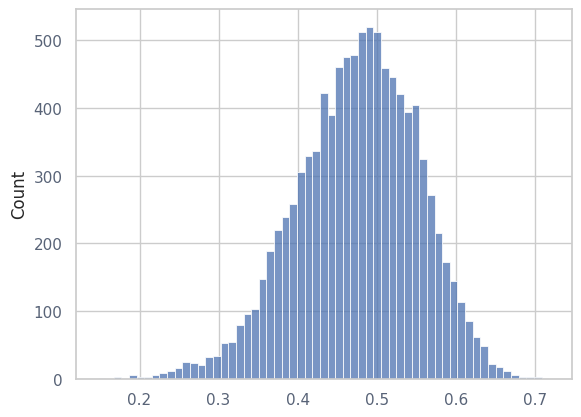

In [45]:
residual_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
residual_model.fit(X_residual_train, Y_train)
residual_score = residual_model.score(X_residual_test, Y_test)
print(residual_score.mean())
sns.histplot(backend.to_numpy(residual_score))